In [1]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler


#basename = op.split(op.dirname(op.realpath(__file__)))[0]
basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
load_library(op.join(basename, 'readWrite'))
from readWrite import readFile
from sys_utils import load_library
#from mongoDB_utils import connect_to_database
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()

model_we = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")
#model_we = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_dim300_minCount3_iter50_26032019")


trainingData = pd.read_csv(op.join(basename, "data", "ManualLabel_TypeDiabetes_Sexe.csv"), usecols=["text", "user_description", "user_name", "user_screen_name", "HasDiabetes", 
                            "Type_Diabetes", "Sexe", "History_HasDiab", "History_TypeDiab", "History_Sex"],
                           #converters={'user_description': lambda x: tt(x)}
                           #converters={'HasDiabetes': lambda x: int(x, 16)}
                          #dtype={'Type_Diabetes':np.int32}
                          )

#trainingData['user_description'].replace("nan", "")

#trainingData['user_description'].replace(np.NaN, "")
print(trainingData.dtypes)
print(trainingData.shape)
#trainingData.text.isnull().values.any()
trainingData.head(5)

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


text                 object
user_description     object
user_name            object
user_screen_name     object
HasDiabetes         float64
Type_Diabetes         int64
Sexe                 object
History_HasDiab      object
History_TypeDiab    float64
History_Sex          object
dtype: object
(1897, 10)


,text,user_description,user_name,user_screen_name,HasDiabetes,Type_Diabetes,Sexe,History_HasDiab,History_TypeDiab,History_Sex
0,@Dmartelz24 @Dterrazas760 Then diabetes Kankle...,Account Manager for Dr.Pepper Snapple Group. D...,Jimmy Martinez,R8TERFAN1,0.0,0,M,NaN,NaN,NaN
1,"Woke up with a 30 blood sugar, hate half a can...",It's worth it.,Kelsey Smith,Kelsey_Smith88,1.0,1,U,NaN,NaN,M
2,I’m going back to my roots. I’m trying shakes ...,Life isn't about surviving the storms...it's a...,Lennie Ledesma,lennieledesma,1.0,0,U,NaN,NaN,M
3,Praying I don’t get diabetes,I'm still not fat I'm just short for my weight...,Regina George 💎,BlowindatPINK_,0.0,0,F,NaN,NaN,NaN
4,Happy world diabetes today💙💙 #t1dstrong https:...,I have a dead pancreas☹️ santiago🐬,riley:),itsRiMay,1.0,1,F,NaN,NaN,NaN


In [2]:
#gender_names = pd.read_csv("gender_names_2017.txt", sep=",")
gender_names = pd.read_csv("/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/data/BabyNames_2018_US_SSA.txt", 
                           sep=",", header=None, names=["name", "gender", "OccurencesName"])

print(gender_names.shape)
gender_names.name = gender_names.name.map(lambda name: name.lower())

#print(gender_names[gender_names["name"] == "olivia"])

def choose_most_occuring_name(df):
    if df.shape[0] == 1: return df
    else:
        maxEl = df.OccurencesName.max(axis=0)
        return df[df["OccurencesName"] == maxEl]

# in duplicate cases (Name exist for male and female) take only the one that occurs more often
gender_names = gender_names.groupby("name",as_index=False).apply(choose_most_occuring_name)
gender_names.reset_index(drop=True, inplace=True)
print(gender_names.shape)

gender_names.head(5)


(32033, 3)
(29536, 3)


,name,gender,OccurencesName
0,aaban,M,7
1,aabid,M,6
2,aabidah,F,5
3,aabir,M,5
4,aabriella,F,6


In [3]:
tweets = "/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull.parquet"

df = readFile(tweets, columns="id, text, user_description, user_name, user_screen_name") \
        .sample(n=12000, random_state=1) 

#df.reset_index(drop=True, inplace=True, level="user_name")

print(df.shape)
print("=")
def get_sex(name):
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        return firstName.lower()
    except:
        return None 

df["firstName"] = df.user_name.map(get_sex)

print(df.shape)
print("gender names:", gender_names.shape)
new = pd.merge(df, gender_names, how='inner', left_on="firstName", right_on="name")
new = new[new.OccurencesName > 500] # take only examples of names that occur often
new = new[["text", "user_description", "user_name", "gender"]]
print(new.shape)


Local mode: Read file..
(12000, 5)
=
(12000, 6)
gender names: (29536, 3)
(3614, 4)


In [4]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)

    return tweet

def labelEncode(sex):
    #print(sex)
    if sex == "M": return(0) 
    elif sex == "F": return(1)
    elif sex == "U": return(2)
    else: return(2)


def create_history_sex_column(row):
    #print(row)
    if row["History_Sex"] == "M": return "M"
    elif row["History_Sex"] == "F": return "F"
    elif row["History_Sex"] == "U": return "U"
    elif pd.isnull(row["History_Sex"]): return row["Sexe"]
    else: print("ERROR: Should not occur:  ", row["Sexe"], ";;;", row["History_Sex"])

trainingData['history_sex_total'] = trainingData.apply (lambda row: create_history_sex_column(row), axis=1)

sex = trainingData.Sexe
history_sex = trainingData.history_sex_total


In [5]:
# APPEND OWN TWEETS THAT ARE MATCHED WITH GENDER LIST
print("trainingData.shape:", trainingData.shape)
print("Own data.shape:", new.shape)

label = "history_sex_total"
data_pd = trainingData[["text", "user_description", "user_name", label]]
new[label] = new["gender"]
del new["gender"]

data_pd = data_pd.append(new, ignore_index=True).sample(frac=1.0) # append dataframes and sample
print("merged.shape:", data_pd.shape)
print(data_pd[label].value_counts())
data_pd.head()

trainingData.shape: (1897, 11)
Own data.shape: (3614, 4)
merged.shape: (5511, 4)
F    2705
M    2431
U     374
Name: history_sex_total, dtype: int64


,text,user_description,user_name,history_sex_total
5504,@TheFoofinator Im gonna use the shit out of In...,Latino 🇬🇹 BG Designer at WB [DC Superhero Girl...,Pablo Leon,M
461,Ugg summoned to provide ass in seat tomorrow f...,"Unemployed former It Gimp, Director of Emailin...",drvcrash,U
1387,imma enjoy this burger now &amp; imma enjoy wa...,i care more about animals than the existence o...,cat möther,U
782,@lyssiedidit Nope her teeth look fine and she ...,"🇹🇹🌴. CAU & TC, Columbia alumna 👩🏽‍🎓. blessed.","savage, not average.",U
704,@thedrtaylor I relate very much to this. My mo...,I am definitely not two kids on top of each ot...,Vincent Adultman,M


In [6]:

data_pd.text = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd["temp_userDesc"] = data_pd.user_description.map(lambda userDesc: 0 
                                                if isinstance(userDesc, float) or userDesc == " " or userDesc == None
                                                else 1)

data_pd.user_description = data_pd.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " or userDesc == None
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))

def userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
        #print("\t FirstName:", firstName)
    except:
        vec = np.zeros((model_we.vector_size, ))
        #print("\t no first name")

    return vec

def TEMP_userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
        return 1
    except:
        #vec = np.zeros((model_we.vector_size, ))
        return 0


#data_pd["temp"] = data_pd.user_name#.map(lambda name: name.split(" ")[0].replace(" ", ""))
data_pd['temp_user_name'] = data_pd.user_name.map(lambda name: TEMP_userName_to_vec(name))
data_pd.user_name = data_pd.user_name.map(lambda name: userName_to_vec(name))
data_pd[label] = data_pd[label].map(labelEncode)


# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text"].apply(lambda x: len(x)>0) ]
print(data_pd.shape)

#data_pd.user_name = data_pd.user_name.map(lambda tweet: prep.remove_non_ascii(tweet))
data_pd.head(3)



no embedding for Ⓐ !!!!!!!!!!!!
no embedding for Ⓐ !!!!!!!!!!!!
no embedding for Ⓛ !!!!!!!!!!!!
no embedding for Ⓐ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,text,user_description,user_name,history_sex_total,temp_userDesc,temp_user_name
5504,"[0.1700673, 0.14555998, 0.07601931, -0.0590527...","[0.20420489, 0.055013817, 0.10469677, -0.01836...","[0.6135887, 0.3374792, -0.17456993, -0.0969173...",0,1,1
461,"[0.17869157, 0.046701387, -0.038702928, -0.125...","[0.16162589, 0.08326687, 0.07272176, -0.047695...","[0.26321453, -0.2030887, -0.01789873, 0.212551...",2,1,1
1387,"[0.113419004, 0.09801392, -0.010433388, -0.155...","[0.026523996, 0.090490885, 0.008935243, 0.0168...","[0.08966822, -0.17140095, -0.39347178, -0.0029...",2,1,1


In [47]:
# Replace missing values by mean of vectors and not by Array of 0

"""
#print(data_pd.shape)
user_desc_nonZero = data_pd[data_pd.temp_userDesc == 1] # only rows with non zero user_description vectors
mean_user_desc = user_desc_nonZero.user_description.mean()
#print(user_desc_nonZero.shape)
print(type(mean_user_desc), mean_user_desc.shape)

user_name_nonZero = data_pd[data_pd.temp_user_name == 1] # only rows with non zero user_description vectors
mean_user_name = user_name_nonZero.user_name.mean()
#print(user_name_nonZero.shape)
print(type(mean_user_name), mean_user_name.shape)

#data_pd.user_description.loc[data_pd.temp_userDesc == 0] = 1#mean_user_desc
#data_pd.user_name.loc[data_pd.temp_user_name == 0] = 1#mean_user_name

#df['c1'].loc[df['c1'] == 'Value'] = 10
#print(data_pd.shape)
#data_pd.head(100)

def set_mean_userName(row):
    if row["temp_user_name"] == 1: return row["user_name"]
    else: return mean_user_name

def set_mean_userDesc(row):
    if row["temp_userDesc"] == 1: return row["user_description"]
    else: return mean_user_desc

data_pd['user_name'] = data_pd.apply (lambda row: set_mean_userName(row), axis=1)
data_pd['user_description'] = data_pd.apply (lambda row: set_mean_userDesc(row), axis=1)

data_pd.head(100)
"""

'\n#print(data_pd.shape)\nuser_desc_nonZero = data_pd[data_pd.temp_userDesc == 1] # only rows with non zero user_description vectors\nmean_user_desc = user_desc_nonZero.user_description.mean()\n#print(user_desc_nonZero.shape)\nprint(type(mean_user_desc), mean_user_desc.shape)\n\nuser_name_nonZero = data_pd[data_pd.temp_user_name == 1] # only rows with non zero user_description vectors\nmean_user_name = user_name_nonZero.user_name.mean()\n#print(user_name_nonZero.shape)\nprint(type(mean_user_name), mean_user_name.shape)\n\n#data_pd.user_description.loc[data_pd.temp_userDesc == 0] = 1#mean_user_desc\n#data_pd.user_name.loc[data_pd.temp_user_name == 0] = 1#mean_user_name\n\n#df[\'c1\'].loc[df[\'c1\'] == \'Value\'] = 10\n#print(data_pd.shape)\n#data_pd.head(100)\n\ndef set_mean_userName(row):\n    if row["temp_user_name"] == 1: return row["user_name"]\n    else: return mean_user_name\n\ndef set_mean_userDesc(row):\n    if row["temp_userDesc"] == 1: return row["user_description"]\n    else:

In [2]:

class ItemSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
    
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, message=""):
        self.message = message
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        print(self.message)
        print("type:", type(X), "len:", X.shape)
        #print(X.head(2))
        return X


In [23]:
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)

    
from imblearn.pipeline import Pipeline    
    
pipeline  = Pipeline([
                #("debuge", Debug("start")),
                #('concatenateTweetAndUserDesc', CombineTweetAndUserDesc(user_desc=user_desc_vec)),
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                    #("debugeq", Debug("text Selector")),
                                ])),
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
                                ('userName', Pipeline([
                                    ('userNameSelector', ItemSelect(key='user_name'))
                                ]))  
                            ],
                )),
                #("debuggg", Debug("before model")),
                ('smote', SMOTE(random_state=12, sampling_strategy="auto",  n_jobs=-1)), #, ratio = 1.0 
                ('model', model),
                #("debuggg", Debug("after model")),

            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : #[{"tweet": 1, "userDesc":1, "userName":1},
#                                                {"tweet": 1, "userDesc":1, "userName":0.8}, 
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.6},
#                                                {"tweet": 1, "userDesc":0.7, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.9, "userName":0.5},
#                                                ],
                                               [
#                                                {"tweet": 1, "userDesc":1, "userName":1}, 
                                                {"tweet": 1, "userDesc":0.3, "userName":0.3}, 
                                                {"tweet": 1, "userDesc":0.5, "userName":0.5},
                                                {"tweet": 1, "userDesc":0.2, "userName":0.5},
                                                {"tweet": 1, "userDesc":0.7, "userName":0.7},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.8}, 
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.8},
#                                                {"tweet": 1, "userDesc":0.5, "userName":0.8},
#                                                {'tweet': 1, 'userDesc': 0.8, 'userName': 1},
#                                                {"tweet": 1, "userDesc":0, "userName":1},
#                                                {"tweet": 0, "userDesc":0, "userName":1}
                                                ],

                'smote__k_neighbors' : [4, 5],

#               # param for SVC
               'model__kernel' : ["linear"],#["linear", "poly", "rbf"],
               'model__C' : [0.1, 0.01],
               'model__tol' : [1e-3, 1e-4],
#               'model__class_weight' : ["balanced", {1:0.5}, {1:1}, {1:1.5}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]
#
#               # param for XGBoost Best: 0.910828 using {'model__learning_rate': 0.05, 'model__reg_alpha': 0, 'model__max_depth': 3, 'model__reg_lambda': 1.5, 'model__n_estimators': 300}
#               'model__max_depth' : [3],#[3,4],
#              'model__learning_rate' : [0.001, 0.01, 0.1],
#               'model__booster' : ["gbtree", "gblinear", "dart"], # ["gblinear"], #
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [100, 150],
#               'model__reg_alpha' : [0, 0.1],
#               'model__reg_lambda' : [0.5, 1.0]


}


In [24]:

def label_encode(sex):
    #print(sex)
    # M = 0, F = 1, U = 2
    if sex == 0: return(-1) 
    else: return(1)


#print(labels.unique())
print("data:", data_pd.shape, type(data_pd))
X = data_pd[["text", "user_description", "user_name"]]
#y = data_pd[label].map(label_encode)
y = data_pd[label]
#print("X :", X.shape, type(X))
#print("y.unique: ", y.unique())

#temp = data_pd.loc[data_pd[label] != 2]
#print("Temp:", temp.shape, type(temp))
#X = temp[["text", "user_description", "user_name"]]
#y = temp[label]#.map(label_encode)
print("X :", X.shape, type(X))
print("y.unique: ", y.unique())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
print("X_train:", X_train.shape, type(X_train))
print("X_test:", X_test.shape, type(X_test))
print("y_train:", y_train.shape, type(y_train))
print("y_test:", y_test.shape, type(y_test))



#    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#    y_train, y_test = y[train_idx], y[test_idx]
    
#    print("X_train:", X_train.shape, type(X_train))

    # Over sample traininig set
    #sm = SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#    ros = RandomOverSampler(random_state=0)
#    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
#    print("X_train_res:", X_train_res.shape, type(X_train_res))

#    X_train_pd = pd.DataFrame(X_train_res, columns=["text", "user_description", "user_name"])
#    X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description", "user_name"])
X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description", "user_name"])
X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description", "user_name"])

print(y_train.unique())
print("Start Grid search...")
#from sklearn.metrics import precision_score, roc_auc_score, make_scorer
#prec_scorer = make_scorer(precision_score, average="micro")
grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-2, verbose=1)#, scoring=prec_scorer)#, scoring="roc_auc")
grid.fit(X_train_pd, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

    #grid.best_estimator_#.fit(X_train_res, y_train_res)
y_pred = grid.best_estimator_.predict(X_test_pd)
#print("F1-Score:", f1_score(y_test, y_pred))
#print("Precision: ",precision_score(y_test, y_pred))
#print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))


    


data: (5511, 6) <class 'pandas.core.frame.DataFrame'>
X : (5511, 3) <class 'pandas.core.frame.DataFrame'>
y.unique:  [0 2 1]
X_train: (3857, 3) <class 'pandas.core.frame.DataFrame'>
X_test: (1654, 3) <class 'pandas.core.frame.DataFrame'>
y_train: (3857,) <class 'pandas.core.series.Series'>
y_test: (1654,) <class 'pandas.core.series.Series'>
[1 0 2]
Start Grid search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 160 out of 160 | elapsed: 18.6min finished



Best: 0.855847 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.5, 'userName': 0.5}}
Accuracy:  0.8621523579201935
Performance overall: 
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       758
           1       0.93      0.89      0.91       788
           2       0.36      0.62      0.46       108

    accuracy                           0.86      1654
   macro avg       0.74      0.79      0.75      1654
weighted avg       0.89      0.86      0.87      1654



In [218]:
NEW

Best: 0.855847 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.5, 'userName': 0.5}}
Accuracy:  0.8621523579201935
Performance overall: 
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       758
           1       0.93      0.89      0.91       788
           2       0.36      0.62      0.46       108

    accuracy                           0.86      1654
   macro avg       0.74      0.79      0.75      1654
weighted avg       0.89      0.86      0.87      1654




# SVC - class
#
# only sex (without history) - SVC 
# Best: 0.441223 using {'model__C': 1.0, 'model__kernel': 'linear', 'model__tol': 0.01}
#
# sex with history - SVC
# Best: 0.496574 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01}
#
# only sex with user description - SCV 
# Best: 0.487612 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.001}
#
# sex with history with user description - SVC -  missing values in userdesc are filled with ones
# Best: 0.541908 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01}

# history_sex, user_description, user_name - SVC -  missing values filled with zeros
# Best: 0.682657 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}

# history_sex, user_description, user_name - SVC - missing values filled with mean
#  Best: 0.676331 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}




# SVC with additional gender data - SMOTE - Taking 5000 random tweets and checking for names
#Best: 0.781409 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.7}}
#Accuracy:  0.7643564356435644
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.84      0.80      0.82       416
#           1       0.88      0.77      0.82       498
#           2       0.33      0.61      0.43        96

#   micro avg       0.76      0.76      0.76      1010
#   macro avg       0.68      0.73      0.69      1010
#weighted avg       0.81      0.76      0.78      1010

# SVC with additional gender data - SMOTE - Taking 8000 random tweets and checking for names
#Best: 0.801309 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8259541984732824
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.87      0.85      0.86       527
#           1       0.93      0.82      0.88       662
#           2       0.42      0.72      0.53       121

#   micro avg       0.83      0.83      0.83      1310
#   macro avg       0.74      0.80      0.75      1310
#weighted avg       0.86      0.83      0.84      1310




# ==============
# TAKE THIS ONE:
# ==============

# SVC with additional gender data - SMOTE - Taking 12000 random tweets and checking for names (can not reproduce)
#Best: 0.844660 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8528009535160905
#Performance overall: 
#              precision    recall  f1-score   support

#   (M)     0       0.92      0.88      0.90       744
#   (F)     1       0.93      0.86      0.89       819
#   (U)     2       0.36      0.65      0.47       115

#   micro avg       0.85      0.85      0.85      1678
#   macro avg       0.74      0.80      0.75      1678
#weighted avg       0.88      0.85      0.86      1678



# SVC with additional gender data - SMOTE - Taking 13000 random tweets and checking for names
#Best: 0.845837 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
#Accuracy:  0.8363431151241535
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.87      0.87      0.87       768
#           1       0.91      0.85      0.88       893
#           2       0.31      0.47      0.37       111

#   micro avg       0.84      0.84      0.84      1772
#   macro avg       0.70      0.73      0.71      1772
#weighted avg       0.86      0.84      0.84      1772




#####
#####
#####

# SVC - M vs. (F,U)
#Best: 0.798102 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
#F1-Score: 0.8560700876095119
#Precision:  0.7862068965517242
#Recall:  0.9395604395604396
#Accuracy:  0.7982456140350878

# SVC - F vs. (M,U)
# Best: 0.778598 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
# F1-Score: 0.8225108225108226
# Precision:  0.76
# Recall:  0.8962264150943396
# Accuracy:  0.7842105263157895

# SVC - U vs. (M,F)
#Best: 0.810852 using {'model__C': 0.5, 'model__class_weight': {1: 1.5}, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.8, 'userName': 0.4}}
#F1-Score: 0.8822314049586778
#Precision:  0.8356164383561644
#Recall:  0.9343544857768052
#Accuracy:  0.8
#Performance overall: 
#              precision    recall  f1-score   support

#    (U)   -1       0.49      0.26      0.34       113
#   (M,F)   1       0.84      0.93      0.88       457

#   micro avg       0.80      0.80      0.80       570
#   macro avg       0.66      0.60      0.61       570
#weighted avg       0.77      0.80      0.77       570


# SVC - ignore U -> M vs F
# Best: 0.810775 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.9, 'userName': 0.4}}
# F1-Score: 0.8875855327468231
# Precision:  0.8021201413427562
# Recall:  0.9934354485776805
# Accuracy:  0.7982456140350878




In [26]:

# SVC - SMOTE - Taking 12000 random tweets and checking for names
#Best: 0.855847 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.5, 'userName': 0.5}}
#Accuracy:  0.8621523579201935
#Performance overall: 
#              precision    recall  f1-score   support

#    (M)    0       0.92      0.87      0.89       758
#    (F)    1       0.93      0.89      0.91       788
#    (U)    2       0.36      0.62      0.46       108

#    accuracy                           0.86      1654
#   macro avg       0.74      0.79      0.75      1654
#weighted avg       0.89      0.86      0.87      1654

from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, 'bestModel_gender_20190709.model', compress = 1)

['bestModel_gender_20190709.model']

Classes before: ['M' 'F' 'U']
unique labels: [0 1 2]
Classes: ['M' 'F' 'U']
Confusion matrix, without normalization
[[657  39  62]
 [ 30 702  56]
 [ 26  15  67]]
Classes before: ['M' 'F' 'U']
unique labels: [0 1 2]
Classes: ['M' 'F' 'U']
Normalized confusion matrix
[[0.87 0.05 0.08]
 [0.04 0.89 0.07]
 [0.24 0.14 0.62]]


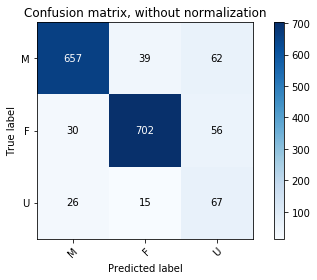

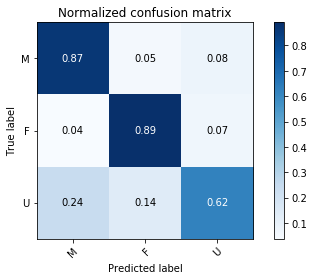

In [27]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

class_names = np.array(["M", "F", "U"])
#class_names = np.array(["M", "F"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Append columns for gender and type of diabetes prediction

In [6]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet

def userName_to_vec(name):
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
    except:
        vec = np.zeros((model_we.vector_size, ))
    return vec

tweets = "/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions.parquet"

df = readFile(tweets) 
del df["emotion"]
del df["__index_level_1__"]
print(df.shape)
print(df.columns)
print(df.head())

Local mode: Read file..
(46407, 37)
Index(['id', 'created_at', 'lang', 'text', 'user_name', 'user_screen_name',
       'user_followers_count', 'user_friends_count', 'user_location',
       'user_description', 'place_full_name', 'retweeted_user_name',
       'retweeted_user_screen_name', 'retweeted_user_followers_count',
       'retweeted_user_friends_count', 'retweeted_user_location',
       'retweeted_user_description', 'retweeted_place_full_name',
       'retweeted_text', 'posted_month', 'tweet_URL_USER', '__index_level_0__',
       'geo_id', 'geo_name', 'geo_code', 'geo_type', 'geo_country_code',
       'geo_city_code', 'geo_adm1_code', 'geo_adm2_code', 'geo_adm3_code',
       'geo_adm4_code', 'pop', '_score_', '_tags_', '_startIndex_',
       '_endIndex_'],
      dtype='object')
             id                      created_at lang  \
0  1.129140e+18  Thu May 16 21:42:52 +0000 2019   en   
1  1.102559e+18  Mon Mar 04 13:17:40 +0000 2019   en   
2  1.039046e+18  Mon Sep 10 07:01:45 +

In [10]:
from sklearn.externals import joblib

temp = pd.DataFrame()
temp["text"] = df.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
temp["user_description"] = df.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " or userDesc == None
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))
temp["user_name"] = df.user_name.map(lambda name: userName_to_vec(name))

gender_classifier = joblib.load("bestModel_gender_20190709.model")
typeDiab_classifier = joblib.load("bestModel_typeDiabetes_20190709.model")

# remove the tweets that are empty because there is no word embedding
#data_pd = data_pd[data_pd["text"].apply(lambda x: len(x)>0) ]

#X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description", "user_name"])

df["gender"] = gender_classifier.predict(temp)
df["typeDiabetes"] = typeDiab_classifier.predict(temp[["text", "user_description"]])
df.head()

no embedding for ㉨ !!!!!!!!!!!!
no embedding for 󾌧 !!!!!!!!!!!!
no embedding for 󾌬 !!!!!!!!!!!!
no embedding for 󾰛 !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for 🧲 !!!!!!!!!!!!
no embedding for ザ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ↽ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Ⓖ !!!!!!!!!!!!
no embedding for Ⓨ !!!!!!!!!!!!
no embedding for Ⓛ !!!!!!!!!!!!
no embedding for ❘ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Я !!!!!!!!!!!!
no embedding for и !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ﹐ !!!!!!!!!!!!
no embedding for ࿐ !!!!!!!!!!!!
no embedding for ࿔ !!!!!!!!!!!!
no embedding for ҉ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Φ !!!!!!!!!!!!
no embedding for Β !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ə !!!!!!!!!!!!
no embedding for ə !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ᵁᴿ !!!!!!!!!!!!
no embedding for ☉ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embe

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for ➚ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ✶ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Θ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ɐ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ۶ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ⬡ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for ☰ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ⠗ !!!!!!!!!!!!
no embedding for ⠏ !!!!!!!!!!!!
no embed

no embedding for ԅ !!!!!!!!!!!!
no embedding for ≖ !!!!!!!!!!!!
no embedding for ≖ !!!!!!!!!!!!
no embedding for ԅ !!!!!!!!!!!!
no embedding for 💈 !!!!!!!!!!!!
no embedding for 💈 !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Я !!!!!!!!!!!!
no embed

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for ❋ !!!!!!!!!!!!
no embedding for ❃ !!!!!!!!!!!!
no embedding for 堀清 !!!!!!!!!!!!
no embedding for ケン悟 !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,id,created_at,lang,text,user_name,user_screen_name,user_followers_count,user_friends_count,user_location,user_description,...,geo_adm2_code,geo_adm3_code,geo_adm4_code,pop,_score_,_tags_,_startIndex_,_endIndex_,gender,typeDiabetes
0,1.129140e+18,Thu May 16 21:42:52 +0000 2019,en,When I was initially diagnosed with #type2diab...,Lynda Jimenez,lyndajimenez22,30.0,70.0,"Phoenix, AZ",Boymom living with LADA #diabetes. Employee a...,...,013,None,None,1.626851,262.320343,"Phoenix,AZ",0,2,1,1
1,1.102559e+18,Mon Mar 04 13:17:40 +0000 2019,en,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,deanna_weick,2222.0,2721.0,"Monroe, MI",Native American Potowatomi adopted out raised...,...,115,None,None,1.231201,225.749695,"Monroe,MI",0,2,0,0
2,1.039046e+18,Mon Sep 10 07:01:45 +0000 2018,en,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,EsmeBayybee,751.0,790.0,Hemet CA,Mom too a Ghoul 💚🕸\nZ.E.R.O👨‍👩‍👧‍👦,...,065,None,None,1.344957,201.460098,"Hemet,CA",0,2,2,0
3,9.581800e+17,Tue Jan 30 03:28:18 +0000 2018,en,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,joycepride,1097.0,3466.0,"Maryville, Missouri",Farm and Ranch Real Estate Locally & Nationwid...,...,147,None,None,1.199328,157.847015,"Maryville,Missouri",0,2,0,0
4,9.151822e+17,Tue Oct 03 11:50:09 +0000 2017,en,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,TattoosandLace,1526.0,757.0,Illinois ✈️ Oklahoma,raised in the North now living in the South. w...,...,109,None,None,1.537132,206.331146,"Illinois,Oklahoma",0,2,2,0


In [13]:
print(df["gender"].value_counts())
print(df["typeDiabetes"].value_counts())

1    20228
0    14485
2    11694
Name: gender, dtype: int64
0    21747
1    20285
2     4375
Name: typeDiabetes, dtype: int64


In [11]:
print(df.columns)
for i, row in df.iterrows():
    print(row["text"])
    print(row["user_description"])
    print(row["user_name"])
    print("gender:", row["gender"], " ##  typeDiab:",row["typeDiabetes"])
    print()
    if i == 100:
        break

Index(['id', 'created_at', 'lang', 'text', 'user_name', 'user_screen_name',
       'user_followers_count', 'user_friends_count', 'user_location',
       'user_description', 'place_full_name', 'retweeted_user_name',
       'retweeted_user_screen_name', 'retweeted_user_followers_count',
       'retweeted_user_friends_count', 'retweeted_user_location',
       'retweeted_user_description', 'retweeted_place_full_name',
       'retweeted_text', 'posted_month', 'tweet_URL_USER', '__index_level_0__',
       'geo_id', 'geo_name', 'geo_code', 'geo_type', 'geo_country_code',
       'geo_city_code', 'geo_adm1_code', 'geo_adm2_code', 'geo_adm3_code',
       'geo_adm4_code', 'pop', '_score_', '_tags_', '_startIndex_',
       '_endIndex_', 'gender', 'typeDiabetes'],
      dtype='object')
When I was initially diagnosed with #type2diabetes almost 10 years ago, I was in a dark place - blaming myself, fee… https://t.co/pLtFgM2wKr
Boymom living with LADA #diabetes.  Employee and advocate for @amdiabetesas

In [14]:
df.columns

Index(['id', 'created_at', 'lang', 'text', 'user_name', 'user_screen_name',
       'user_followers_count', 'user_friends_count', 'user_location',
       'user_description', 'place_full_name', 'retweeted_user_name',
       'retweeted_user_screen_name', 'retweeted_user_followers_count',
       'retweeted_user_friends_count', 'retweeted_user_location',
       'retweeted_user_description', 'retweeted_place_full_name',
       'retweeted_text', 'posted_month', 'tweet_URL_USER', '__index_level_0__',
       'geo_id', 'geo_name', 'geo_code', 'geo_type', 'geo_country_code',
       'geo_city_code', 'geo_adm1_code', 'geo_adm2_code', 'geo_adm3_code',
       'geo_adm4_code', 'pop', '_score_', '_tags_', '_startIndex_',
       '_endIndex_', 'gender', 'typeDiabetes'],
      dtype='object')

In [15]:
df.to_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions_gender-typeDiab.parquet", 
                       engine="pyarrow", index=False)